In [1]:
%matplotlib inline
import pandas as pd
import sklearn.cluster
import matplotlib.pyplot as plt
import numpy as np
from osgeo import gdal
#import gdal
from affine import Affine
import pyproj
import sys
import os
from IPython import display
%matplotlib inline

sys.path.append("/Users/opizarro/git/bathypred")
import renavutils3 as rutil
from image_prep import pack_images, pack_bpatches


In [2]:
# stereo pose file
pose_file = '/Volumes/Samsung_T3/PROCESSED_DATA/Tasmania200810/r20081007_224547_ohara_07_transect/renav20160205/stereo_pose_est.data'

image_dir = '/Volumes/Samsung_T3/PROCESSED_DATA/Tasmania200810/r20081007_224547_ohara_07_transect/i20081007_224547_cv'

#bathymetry
bathy_all = '/Volumes/Samsung_T3/Tassie_bathy/Tasmania200810/TAFI_provided_data/BathymetryAsTiffs/fort1.tif'
utm_proj = pyproj.Proj('+proj=utm +zone=55G, +south +ellps=WGS84')


# corresponding bathy patches
bpatch_dir = '/Volumes/Samsung_T3/bathy_training/bathy_patches_ohara_07'

# cached images
cached_images = '/Volumes/Samsung_T3/bathy_training/cache_images_ohara_07.npz'

# cached bathymetry 
cached_bpatches = '/Volumes/Samsung_T3/bathy_training/cache_bpatches_ohara_07.npz'


In [3]:
# parameters
half_patch = 10
bpsize = 2*half_patch+1 # bathy patch size in pixels



patch_suffix = "bp" + str(bpsize) +".npy"



In [4]:
def retrieve_pixel_coords(geo_coord,geot_params):
    x, y = geo_coord[0], geo_coord[1]
    forward_transform =  Affine.from_gdal(*geot_params)
    reverse_transform = ~forward_transform
    px, py = reverse_transform * (x, y)
    #print('px size ', px.size)
    #px = int(px + 0.5)
    #py = int(py + 0.5)
    px = np.around(px).astype(int)
    py = np.around(py).astype(int)
    pixel_coord = px, py
    return pixel_coord

In [5]:
def maybe_makedir(dirname, force=False):
  if os.path.isdir(dirname) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping making dir' % (dirname))
  else:
    print('Making dir %s.' % dirname)
    os.makedirs(dirname)
  return 

Driver: GTiff/GeoTIFF
Size is 5161 x 14044 x 1
Projection is PROJCS["WGS 84 / UTM zone 55S",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",147],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32755"]]
Origin = (576177.38, 5249984.72)
Pixel Size = (2.0, -2.0)


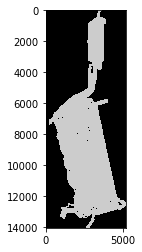

In [6]:
# test section of input data
in_ds = gdal.Open(bathy_all)



print("Driver: {}/{}".format(in_ds.GetDriver().ShortName,
                             in_ds.GetDriver().LongName))
print("Size is {} x {} x {}".format(in_ds.RasterXSize,
                                    in_ds.RasterYSize,
                                    in_ds.RasterCount))
print("Projection is {}".format(in_ds.GetProjection()))
geotransform = in_ds.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))
    
    
plt.figure(1)
plt.imshow(in_ds.GetRasterBand(1).ReadAsArray(), cmap = "nipy_spectral")

In [7]:
def extract_bathy_patch(gdal_raster,off_ulx,off_uly,patch_size):
    columns = patch_size
    rows = patch_size
    patch_data = gdal_raster.GetRasterBand(1).ReadAsArray(off_ulx, off_uly, columns, rows)
    return patch_data
    

In [8]:
renav, o_lat, o_lon, ftype = rutil.read_renav(pose_file)
print(ftype)
#renav = rutil.read_renav(pose_file)

stereo


In [9]:
maybe_makedir(bpatch_dir)

depth_nav = []
depth_bathy = []
# for each image, 
for i, im in enumerate(renav['leftim']):
    
    # get coordinates in lat lon
    # convert to pixel coords
    x,y = utm_proj(renav['longitude'][i],renav['latitude'][i])
    #print("lon lat, {},{}".format(renav['longitude'][i],renav['latitude'][i]))
    #print("utm {},{}".format(x,y))
    # convert UTM x,y coords into pixel coords 
    px, py = retrieve_pixel_coords([x,y], list(geotransform))
    # calculate offsets
    off_x = px - half_patch
    off_y = py - half_patch
   
    off_x = int(np.round(off_x))
    off_y = int(np.round(off_y))
   
    # cut out the bathy patch that corresponds
    #print (off_x,off_y,bpsize)
    bathy_patch = extract_bathy_patch(in_ds,off_x,off_y, bpsize)
    # plot
    if 0:
        plt.figure(10)
        plt.imshow(bathy_patch)
        # to refresh in place
        display.display(plt.gcf())
        display.clear_output(wait=True)
    # save with same name as image - different suffix (scale)
    patch_name = im.replace("LC16.png",patch_suffix)
    # print overwriting same line
    print('\r', 'Image ', i, ' Name: ', patch_name, end='')
    np.save(os.path.join(bpatch_dir,patch_name),bathy_patch)
    
    depth_nav[i] = renav['Zpos'][i] + renav['altitude'][i]
    depth_bathy[i] = bathy_patch[half_patch,half_patch]

plt.figure(11)
plt.plot(depth_nav)
plt.plot(depth_bathy)
plt.legend(['auv','bathy'])

/Volumes/Samsung_T3/bathy_training/bathy_patches_ohara_07 already present - Skipping making dir
 Image  11277  Name:  PR_20081008_021105_662_bp21.npyPR_20081008_000858_653_bp21.npy

In [12]:
(Im_train,_, packed_image_list) = pack_images(image_dir,cached_images)


number of images 11278
cache not available, loading individual images
 processing image number 11200 name PR_20081008_020948_651_LC16.png 

In [13]:
(Bp_train,_) = pack_bpatches(bpatch_dir, cached_bpatches, packed_image_list, bpsize )

processing bpatch for image number 0 name PR_20081007_230307_118_LC16.png 
processing bpatch for image number 100 name PR_20081007_230447_129_LC16.png 
processing bpatch for image number 200 name PR_20081007_230627_147_LC16.png 
processing bpatch for image number 300 name PR_20081007_230807_158_LC16.png 
processing bpatch for image number 400 name PR_20081007_230947_173_LC16.png 
processing bpatch for image number 500 name PR_20081007_231127_189_LC16.png 
processing bpatch for image number 600 name PR_20081007_231307_199_LC16.png 
processing bpatch for image number 700 name PR_20081007_231447_216_LC16.png 
processing bpatch for image number 800 name PR_20081007_231627_230_LC16.png 
processing bpatch for image number 900 name PR_20081007_231807_243_LC16.png 
processing bpatch for image number 1000 name PR_20081007_231947_256_LC16.png 
processing bpatch for image number 1100 name PR_20081007_232127_267_LC16.png 
processing bpatch for image number 1200 name PR_20081007_232307_284_LC16.png

processing bpatch for image number 10800 name PR_20081008_020308_594_LC16.png 
processing bpatch for image number 10900 name PR_20081008_020448_608_LC16.png 
processing bpatch for image number 11000 name PR_20081008_020628_627_LC16.png 
processing bpatch for image number 11100 name PR_20081008_020808_640_LC16.png 
processing bpatch for image number 11200 name PR_20081008_020948_651_LC16.png 
